In [1]:
from entsoe import EntsoePandasClient, mappings
from dotenv import load_dotenv
import pandas as pd
import itertools
import os
from tqdm import tqdm
import geopandas as gpd
import geodatasets as gds
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import matplotlib.pyplot as plt

In [2]:
load_dotenv()  # load env file
entsoe_key = os.getenv("ENTSOE_API_KEY")  # Get API keys from .env file

# Instantiate the ENTSOE Client
client = EntsoePandasClient(api_key=entsoe_key)

# Data Query

In [3]:
start_date = pd.Timestamp(year=2024, month=8, day=1, tz="utc")
end_date = pd.Timestamp(year=2024, month=8, day=2, tz="utc")

# Define the countries, CORE CCR countries are: AT BE HR CZ FR DE HU LU NL PL RO SK SI   
countries = ["AT", "BE", "CZ", "FR", "DE_LU", "HU","NL", "PL", "RO", "SK", "SI", "PL", "CH"]

# Define the neighbors of the countries
neighbors = mappings.NEIGHBOURS

In [4]:
# Query the data and save it to a csv file
country_pairs = (
    pd.DataFrame(itertools.product(countries, countries))
    .rename(columns={0: "flow_from", 1: "flow_to"})
    .drop_duplicates()
    .query("flow_from != flow_to")
    .reset_index(drop=True)
)

In [5]:
# Create a list of valid pairs
valid_pairs = []
for country, neighbors_list in neighbors.items():
    for neighbor in neighbors_list:
        if country in countries and neighbor in countries:
            valid_pairs.append((country, neighbor))
            valid_pairs.append((neighbor, country))  # Include both directions

# Convert the list of valid pairs into a DataFrame
valid_pairs_df = pd.DataFrame(valid_pairs, columns=["flow_from", "flow_to"])

# Merge with the original country_pairs to filter only valid pairs
filtered_country_pairs = pd.merge(country_pairs, valid_pairs_df, on=["flow_from", "flow_to"]).drop_duplicates()

# filtered_country_pairs now contains only the valid flows based on neighbors

In [6]:
# Initialize an empty list to store individual dictionaries
all_flows = []

# Loop through each index in filtered_country_pairs
for idx in tqdm(filtered_country_pairs.index):
    data = client.query_crossborder_flows(
        country_code_from=filtered_country_pairs.loc[idx, "flow_from"],
        country_code_to=filtered_country_pairs.loc[idx, "flow_to"],
        start=start_date,
        end=end_date,
    )
    # Extract the maximum value from the returned series
    max_value = data.max() if not data.empty else None
    # Store the result in a dictionary
    flow_dict = {
        "flow_from": filtered_country_pairs.loc[idx, "flow_from"],
        "flow_to": filtered_country_pairs.loc[idx, "flow_to"],
        "max_value": max_value
    }
    # Append the dictionary to the list
    all_flows.append(flow_dict)

# Convert the list of dictionaries into a single dataframe
flow_df = pd.DataFrame(all_flows)

100%|██████████| 40/40 [00:06<00:00,  5.73it/s]


In [7]:
# save to parquet
flow_df.to_parquet("maps/flow_data.parquet")

# Flow Visualization

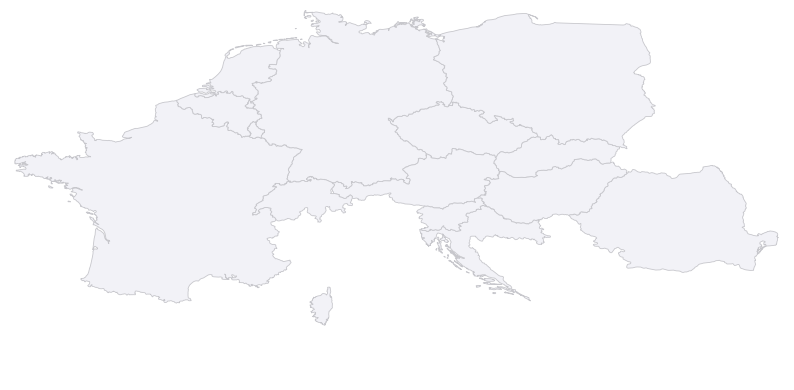

In [9]:
countrynames = ["France", "Germany", "Austria", "Switzerland", "Belgium", "Netherlands", "Poland", "Czechia", "Slovakia", "Hungary", "Croatia", "Slovenia", "Luxembourg", "Romania"]
# Filter the GeoDataFrame
world = gpd.read_file('maps/ne_10m_admin_0_countries.shp')
europe_subset = world[world['ADMIN'].isin(countrynames)]

# Plot the filtered map
fig, ax = plt.subplots(figsize=(10, 10))
europe_subset.plot(ax=ax, color='#f2f2f7', edgecolor='#c7c7cc', linewidth=0.6)
# Set limits to focus the map view
ax.set_xlim(-5, 30)  # Longitude range for Europe
ax.set_ylim(39, 55)   # Latitude range for Europe
# Turn off the axes
ax.axis('off')

plt.show()

In [23]:
flow_df.head()

,flow_from,flow_to,max_value
0,AT,CZ,0.0
1,AT,DE_LU,1329.0
2,AT,HU,1260.0
3,AT,SI,237.0
4,AT,CH,41.0
